In [159]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns

In [160]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [161]:
X, y = mnist["data"], mnist["target"]

In [162]:
# 메모리 이슈로 인해 데이터를 축소해 실행한다
X, y = X[:20000], y[:20000]

In [163]:
y = y.astype(np.uint8).to_numpy()

In [164]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

In [165]:
print(f'Original: {y.shape}') # 1차원 label array
print(f'np.newaxis: {y[:, np.newaxis].shape}') # 2차원 array로 만들어준다
print(f'np.newaxis: {y[np.newaxis, :].shape}') # Transpose하여 행벡터로 사용

Original: (20000,)
np.newaxis: (20000, 1)
np.newaxis: (1, 20000)


In [166]:
# np.newaxis: 이미 존재하는 어떤 numpy array의 차원을 늘려주는 역할
enc.fit(y[:,np.newaxis])

OneHotEncoder()

In [167]:
Y = enc.transform(y[:,np.newaxis]).toarray()

In [168]:
print(Y.shape)
Y

(20000, 10)


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [169]:
X_train, X_val, X_test, y_train, y_val, y_test = X[:16000], X[16000:18000], X[18000:], Y[:16000], Y[16000:18000], Y[18000:]

In [170]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [171]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [172]:
def softmax(X, W):
    K = np.size(W, 1)
    A = np.exp(X @ W)
    # np.diag -> array 형태여야하므로, np.reshape(***, -1)을 통해 1차원 array로 변형시켜준 것
    B = np.diag(1 / (np.reshape(A @ np.ones((K,1)), -1))) # 역행렬을 구하는 것을 조금 더 간단하게 만들기 위한 식
    Y = B @ A
    return Y

In [173]:
# Multiclass Logistic Regression
def compute_cost(X, T, W):
    epsilon = 1e-5
    N = len(T)
    K = np.size(T, 1)
    # np.multiply: element-wise multiplication
    # Negative log-likelihood식을 행렬곱 형태로 정리한 형태
    cost = - (1/N) * np.ones((1,N)) @ (np.multiply(np.log(softmax(X, W) + epsilon), T)) @ np.ones((K,1)) 
    return cost

## Regularization
머신러닝 모델의 과적합(Overfitting)을 막는 방법은 다음과 같다.
- Batch Normalization(배치정규화)
- Weight Regularization(정규화)
- Dropout(학습 시 랜덤으로 뉴런의 일부만을 사용)
- Early Stopping(오버피팅이 되기 전에 학습을 정지)

이 중 Weight Regularization은 L1, L2 Regularization을 사용한다.

### L1, L2 Regularization
학습을 진행할 때, 학습 데이터의 특성에 따라서 특정 weight의 값이 지나치게 커질 수 있다. 이 때 overfitting이 쉽게 발생하게 된다. 이를 방지하기 위해서 weight의 값을 작게 유지해주기 위한 방법으로 Loss function에 일정한 값을 추가해준다. 이를 통해서 Loss와 Model Complexity를 최소화시키는 방식으로 식이 변형된다.

$ minimize(Loss(Data|Model) + Complexity(Model)) $

여기서 모델의 복잡도(Complexity)를 계산하기 위해서 weight값의 최소값을 구하는 방식을 사용하는데, L1의 경우 weight의 절대값의 최소값을, L2의 경우는 weight의 제곱합에 대한 최소값을 구한다.

여기에 각 Regularization값의 강도를 조절하기 위해 람다 값을 곱해준다. 람다값이 0에 가까울수록 정규화가 적게 이루어져 overfitting이 쉽게 발생하게 된다.
$ minimize(Loss(Data|Model) + \lambda  Complexity(Model)) $

이 때, 선형회귀모델에서 L1규제를 주는 것이 Lasso Regression, L2규제를 주는 것을 Ridge Regression이라고 한다. 이 둘을 동싱 사용하는 방식도 사용 가능하다.

L1규제의 경우, 가중치 업데이트 시 작은 가중치들은 0에 수렴하게 된다. 따라서 몇 개의 중요한 weight만이 남게 된다. 따라서 소수의 의미 있는 값을 도출(feature selection 효과)해내고 싶은 sparse한 모델의 경우에 적합하게 사용 가능하다. 그러나 L1규제의 경우 미분이 불가능한 영역이 존재하기 때문에, Gradient-base learning에서는 주의하여 사용해야 한다.

L2의 경우는 불필요한 feature의 weight를 0에 가깝게 만들 뿐 0으로 만들지는 않는다. 이런 특성으로 인해 L1에 비해서 상대적으로 선형모델의 일반화 능력이 더 뛰어나다고 볼 수 있다.

In [174]:
# Multiclass Logistic Regression with L2 Regularization
def L2_compute_cost(X, T, W, lambda_value):
    epsilon = 1e-5
    N = len(T)
    K = np.size(T, 1)
    # L2 Regularization을 추가
    ridge_reg_term = (1 / N) * (lambda_value / 2) * np.sum(np.square(W))
    cost = - (1/N) * np.ones((1,N)) @ (np.multiply(np.log(softmax(X, W) + epsilon), T)) @ np.ones((K,1)) + ridge_reg_term
    return cost

In [175]:
def predict(X, W):
    return np.argmax((X @ W), axis=1)

In [176]:
# Mini batch
def batch_gd(X, T, W, learning_rate, iterations, batch_size):
    N = len(T)
    cost_history = np.zeros((iterations,1))
    shuffled_indices = np.random.permutation(N)
    X_shuffled = X[shuffled_indices]
    T_shuffled = T[shuffled_indices]

    for i in range(iterations):
        j = i % N
        X_batch = X_shuffled[j:j+batch_size]
        T_batch = T_shuffled[j:j+batch_size]
        # batch가 epoch 경계를 넘어가는 경우, 앞 부분으로 채워줌
        if X_batch.shape[0] < batch_size:
            X_batch = np.vstack((X_batch, X_shuffled[:(batch_size - X_batch.shape[0])]))
            T_batch = np.vstack((T_batch, T_shuffled[:(batch_size - T_batch.shape[0])]))
        W = W - (learning_rate/batch_size) * (X_batch.T @ (softmax(X_batch, W) - T_batch))
        cost_history[i] = compute_cost(X_batch, T_batch, W)
        if i % 1000 == 0:
            print(cost_history[i][0])

    return (cost_history, W)

In [184]:
# Batch gradient descent with L2 Regularization
def L2_batch_gd(X, T, W, learning_rate, iterations, batch_size, lambda_value):
    N = len(T)
    cost_history = np.zeros((iterations,1))
    shuffled_indices = np.random.permutation(N)
    X_shuffled = X[shuffled_indices]
    T_shuffled = T[shuffled_indices]

    for i in range(iterations):
        j = i % N
        X_batch = X_shuffled[j:j+batch_size]
        T_batch = T_shuffled[j:j+batch_size]
        
        if X_batch.shape[0] < batch_size:
            X_batch = np.vstack((X_batch, X_shuffled[:(batch_size - X_batch.shape[0])]))
            T_batch = np.vstack((T_batch, T_shuffled[:(batch_size - T_batch.shape[0])]))
        
        error = softmax(X_batch, W) - T_batch
        # L2 Regularization이 Cost function에 추가되었으므로, Gradient 또한 L2 Reg term의 미분 값이 포함되어야 한다
        gradient = ((1 / batch_size) * (X_batch.T @ error)) + (lambda_value * W)
        W = W - (learning_rate * gradient)
        cost_history[i] = L2_compute_cost(X_batch, T_batch, W, lambda_value)
#         if i % 1000 == 0:
#             print(cost_history[i][0])

    return (cost_history, W)

In [178]:
X = np.hstack((np.ones((np.size(X_train, 0),1)),X_train))
T = y_train

K = np.size(T, 1)
M = np.size(X, 1)
W = np.zeros((M,K))

iterations = 40000
learning_rate = 0.01

initial_cost = compute_cost(X, T, W)

print("Initial Cost is: {} \n".format(initial_cost[0][0]))

(cost_history, W_optimal) = batch_gd(X, T, W, learning_rate, iterations, 64)

Initial Cost is: 2.3024850979937064 

2.2781058397920453
0.6440957439045665
0.4950422274292434
0.3144196482201307
0.5700995473398927
0.313889265100568
0.2790729748229268
0.31092182567930615
0.3146507381362376
0.25294554648986595
0.3068798570554068
0.33446675532219716
0.26829306200060504
0.2943049730367556
0.23267393299251854
0.19377027437887567
0.3947743456983794
0.32701703116532965
0.31710260776970917
0.18037625034621996
0.49203315952189797
0.19477569459452868
0.22433469558129784
0.2555142504706855
0.2531679029670873
0.18610515363288616
0.23896183341331595
0.3169286891552077
0.22783713749881893
0.24837803955804372
0.2053362314969377
0.16047932358869932
0.3479142492643788
0.2918579738455747
0.2660212162094761
0.15732797071432353
0.4823995515629624
0.164992785725649
0.21452123058385264
0.2408870109318988


In [179]:
# Gradient Descent with L2 Regularization
X = np.hstack((np.ones((np.size(X_train, 0),1)),X_train))
T = y_train

K = np.size(T, 1)
M = np.size(X, 1)
W = np.zeros((M,K))

iterations = 40000
learning_rate = 0.01
lambda_value = 0.001

initial_cost = L2_compute_cost(X, T, W, lambda_value)

print("Initial Cost is: {} \n".format(initial_cost[0][0]))

(cost_history_L2, W_optimal_L2) = L2_batch_gd(X, T, W, learning_rate, iterations, 64, lambda_value)

Initial Cost is: 2.3024850979937064 

2.279969397003856
0.5102137134772081
0.3625999265336366
0.40698701855948377
0.32044333366664746
0.2756165209644355
0.3848762436818735
0.36208797616485366
0.3430986652013604
0.21848048906660586
0.277361972482939
0.19522204073878255
0.19741469261499575
0.22395556166071703
0.48259391058829987
0.43676029642502473
0.3921078345103752
0.18599769397910476
0.1734229667923922
0.27258622412542666
0.24349069032197262
0.19276928627733347
0.3448951253797428
0.29501675626003926
0.26780346440167613
0.17606874561319066
0.23229832706847275
0.15204424313613246
0.17392881645533784
0.19135855558644083
0.4490819971411461
0.39991445470780274
0.3654727353768001
0.1683911995540845
0.155411795241743
0.25410652360471453
0.21920935766330935
0.17933523646201335
0.3368626133614661
0.2717386791313132
0.24454171832841765
0.16464042576411064
0.21613847407538397
0.1395473243920405
0.16594843223759295
0.18306085966938482
0.43499369180910463
0.3851983705017569
0.35271865294586496
0.1

In [182]:
# Gradient Descent with L2 Regularization
def get_optimal_weight(X_train, y_train, lambda_value):
    X = np.hstack((np.ones((np.size(X_train, 0),1)),X_train))
    T = y_train

    K = np.size(T, 1)
    M = np.size(X, 1)
    W = np.zeros((M,K))

    iterations = 40000
    learning_rate = 0.01

#     initial_cost = L2_compute_cost(X, T, W, lambda_value)
#     print("Initial Cost is: {} \n".format(initial_cost[0][0]))

    (cost_history_L2, W_optimal_L2) = L2_batch_gd(X, T, W, learning_rate, iterations, 64, lambda_value)
    return W_optimal_L2

In [180]:
## Accuracy
X_ = np.hstack((np.ones((np.size(X_test, 0),1)),X_test))
T_ = y_test
y_pred = predict(X_, W_optimal)
score = float(sum(y_pred == np.argmax(T_, axis=1)))/ float(len(y_test))

print(score)

0.918


In [181]:
## L2 Accuracy
X_ = np.hstack((np.ones((np.size(X_test, 0),1)),X_test))
T_ = y_test
y_pred = predict(X_, W_optimal_L2)
score = float(sum(y_pred == np.argmax(T_, axis=1)))/ float(len(y_test))

print(score)

0.926


In [185]:
## get optimal L2 lambda value
X_ = np.hstack((np.ones((np.size(X_val, 0),1)),X_val))
T_ = y_val
lambda_values = [0, 0.1, 0.01, 0.001, 0.0001]
scores = []

for l_value in lambda_values:
    W_ = get_optimal_weight(X_train, y_train, l_value)
    y_pred = predict(X_, W_)
    score = float(sum(y_pred == np.argmax(T_, axis=1)))/ float(len(y_test))
    print(score)
    scores.append(score)

0.892
0.8285
0.8765
0.8965
0.898


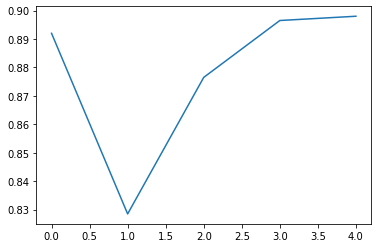

In [186]:
import matplotlib.pyplot as plt

plt.plot(scores)
plt.show()